In [4]:
import pandas as pd

In [5]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [9]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

c:\Users\PC\Desktop\ML\Q2-2022\MLops ZoomCamp\Module Two\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\PC\Desktop\ML\Q2-2022\MLops ZoomCamp\Module Two\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


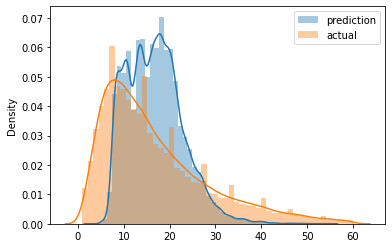

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [19]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [20]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Ephraim")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")


    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    mse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", mse)

In [2]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [28]:
def objective(params):

    with mlflow.start_run():
        
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[14:57:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.33837                          
[1]	validation-rmse:12.98786                          
[2]	validation-rmse:10.72684                          
[3]	validation-rmse:9.24652                           
[4]	validation-rmse:8.30028                           
[5]	validation-rmse:7.70804                           
[6]	validation-rmse:7.33701                           
[7]	validation-rmse:7.10536                           
[8]	validation-rmse:6.95595                           
[9]	validation-rmse:6.86078                           
[10]	validation-rmse:6.79744                          
[11]	validation-rmse:6.75558                          
[12]	validation-rmse:6.72325                          
[13]	validation-rmse:6.70009                          
[14]	validation-rmse:6.68167                         

: 

: 

In [22]:
params = {
    'learning_rate' : 0.204721,
    'max_depth' : 17,
    'min_child_weight': 1.2042611,
    'objective' : 'reg:linear',
    'reg_alpha' : 0.285678,
    'reg_lambda' : 0.0042644,
    'seed' : 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
)

2022/06/01 15:23:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ea8c73ea8c8d430a9cb61cf03d9d5420', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:23:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.57672
[1]	validation-rmse:14.77952
[2]	validation-rmse:12.64201
[3]	validation-rmse:11.02822
[4]	validation-rmse:9.82438
[5]	validation-rmse:8.93795
[6]	validation-rmse:8.29598
[7]	validation-rmse:7.82923
[8]	validation-rmse:7.49423
[9]	validation-rmse:7.25124
[10]	validation-rmse:7.07617
[11]	validation-rmse:6.94885
[12]	validation-rmse:6.85679
[13]	validation-rmse:6.78789
[14]	validation-rmse:6.73514
[15]	validation-rmse:6.69523
[16]	validation-rmse:6.66330
[17]	validation-rmse:6.64037
[18]	validation-rmse:6.62226
[19]	validation-rmse:6.60733
[20]	validation-rmse:6.59614
[21]	validation-rmse:6.58815
[22]	validation-rmse:6.58247
[23]	validation-rmse:6.57662
[24]	validation-rmse:6.57243
[25]	validation-rmse:6.56791
[26]	validation-rmse:6.56230
[27]	validation-rmse:6.55841
[28]	validation-r

2022/06/01 15:26:29 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


In [26]:
mlflow.xgboost.autolog(disable=True)

In [27]:
with mlflow.start_run():
    best_params = {
        'learning_rate' : 0.204721,
        'max_depth' : 17,
        'min_child_weight': 1.2042611,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.285678,
        'reg_lambda' : 0.0042644,
        'seed' : 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    
    

[15:44:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.57672
[1]	validation-rmse:14.77952
[2]	validation-rmse:12.64201
[3]	validation-rmse:11.02822
[4]	validation-rmse:9.82438
[5]	validation-rmse:8.93795
[6]	validation-rmse:8.29598
[7]	validation-rmse:7.82923
[8]	validation-rmse:7.49423
[9]	validation-rmse:7.25124
[10]	validation-rmse:7.07617
[11]	validation-rmse:6.94885
[12]	validation-rmse:6.85679
[13]	validation-rmse:6.78789
[14]	validation-rmse:6.73514
[15]	validation-rmse:6.69523
[16]	validation-rmse:6.66330
[17]	validation-rmse:6.64037
[18]	validation-rmse:6.62226
[19]	validation-rmse:6.60733
[20]	validation-rmse:6.59614
[21]	validation-rmse:6.58815
[22]	validation-rmse:6.58247
[23]	validation-rmse:6.57662
[24]	validation-rmse:6.57243
[25]	validation-rmse:6.56791
[26]	validation-rmse:6.56230
[27]	validation-rmse:6.55841
[28]	validation-r